In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from pathlib import Path
import logging
from datetime import datetime
import json
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, 
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    pipeline,
)
from datasets import Dataset, load_dataset

import chardet
import re

In [6]:
data_dir = Path('.').resolve() / '.datasets'

# Politican Social Media

https://www.kaggle.com/datasets/crowdflower/political-social-media-posts?select=political_social_media.csv

This is quite old data I think - about 9 years ago...

There's a `chardet` library that can help detected encoding of files.
Data requires proper treatment so using it here. 

In [7]:
political_social_media_data = data_dir / 'political_social_media.parquet'
assert political_social_media_data.exists()

skip_01 = True

if not skip_01:
    with open(political_social_media_data, 'rb') as file:
        # print(chardet.detect(file.read()))
        # {'encoding': 'MacRoman', 'confidence': 0.7153802875532049, 'language': ''}
        first_bytes = file.read(25)
        print(first_bytes)

In [8]:
dfpsm = pd.read_parquet(political_social_media_data)
dfpsm.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,...,orig__golden,audience_gold,bias_gold,bioid,embed,id,label,message_gold,source,text
0,766192484,False,finalized,1,8/4/15 21:17,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,R000596,"<blockquote class=""twitter-tweet"" width=""450"">...",3.83249E+17,From: Trey Radel (Representative from Florida),NaN,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0,attack,...,NaN,NaN,NaN,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),NaN,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,False,finalized,1,8/4/15 21:14,national,1.0,neutral,1.0,support,...,NaN,NaN,NaN,S001180,"<blockquote class=""twitter-tweet"" width=""450"">...",3.39069E+17,From: Kurt Schrader (Representative from Oregon),NaN,twitter,Please join me today in remembering our fallen...
3,766192487,False,finalized,1,8/4/15 21:08,national,1.0,neutral,1.0,policy,...,NaN,NaN,NaN,C000880,"<blockquote class=""twitter-tweet"" width=""450"">...",2.98528E+17,From: Michael Crapo (Senator from Idaho),NaN,twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,False,finalized,1,8/4/15 21:26,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,U000038,"<blockquote class=""twitter-tweet"" width=""450"">...",4.07643E+17,From: Mark Udall (Senator from Colorado),NaN,twitter,.@amazon delivery #drones show need to update ...


In [9]:
# flyweight

dfpsmfw = dfpsm.copy()
dfpsmfw['id'] = dfpsm['_unit_id']
dfpsmfw = dfpsmfw[['id', 'bias', 'message', 'source', 'text']]
print(json.dumps({
    'cols': list(dfpsmfw.columns),
    'audience': dfpsmfw['bias'].value_counts().to_dict(),
    'message': dfpsmfw['message'].value_counts().to_dict(),
    'sources': dfpsmfw['source'].value_counts().to_dict(),
    }, indent=2))

{
  "cols": [
    "id",
    "bias",
    "message",
    "source",
    "text"
  ],
  "audience": {
    "neutral": 3689,
    "partisan": 1311
  },
  "message": {
    "policy": 1411,
    "personal": 1170,
    "support": 921,
    "information": 647,
    "media": 277,
    "attack": 172,
    "constituency": 152,
    "mobilization": 129,
    "other": 121
  },
  "sources": {
    "twitter": 2500,
    "facebook": 2500
  }
}


In [10]:
dfpsm.describe()

,_unit_id,_trusted_judgments,audience:confidence,bias:confidence,message:confidence,orig__golden,audience_gold,bias_gold,message_gold
count,5.000000e+03,5000.00000,5000.000000,5000.000000,5000.000000,0.0,0.0,0.0,0.0
mean,7.661950e+08,1.03280,0.995253,0.993903,0.996215,NaN,NaN,NaN,NaN
std,1.444060e+03,0.18366,0.046920,0.053241,0.041798,NaN,NaN,NaN,NaN
min,7.661925e+08,1.00000,0.505500,0.502000,0.502000,NaN,NaN,NaN,NaN
25%,7.661937e+08,1.00000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN
50%,7.661950e+08,1.00000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN
75%,7.661962e+08,1.00000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN
max,7.661975e+08,3.00000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN


In [11]:
def analyze_text_length_simple(df, text_col='text', dataset_name='Dataset'):
    """
    Analyze text length statistics for simple datasets (like political tweets).
    """
    print(f"=== {dataset_name.upper()} TEXT LENGTH ANALYSIS ===\n")
    
    # Calculate text lengths
    df = df.copy()
    df['text_length'] = df[text_col].str.len()
    
    # Calculate statistics
    lengths = df['text_length']
    mean_len = lengths.mean()
    median_len = lengths.median()
    std_len = lengths.std()
    mode_result = stats.mode(lengths, keepdims=True)
    mode_len = mode_result.mode[0] if len(mode_result.mode) > 0 else np.nan
    
    # Percentiles
    p25 = lengths.quantile(0.25)
    p75 = lengths.quantile(0.75)
    p90 = lengths.quantile(0.90)
    p95 = lengths.quantile(0.95)
    
    # Create summary
    summary = {
        'Dataset': dataset_name,
        'Total Posts': len(df),
        'Mean': round(mean_len, 2),
        'Median': round(median_len, 2),
        'Mode': mode_len,
        'Std Dev': round(std_len, 2),
        '25th Percentile': round(p25, 2),
        '75th Percentile': round(p75, 2),
        '90th Percentile': round(p90, 2),
        '95th Percentile': round(p95, 2),
        'Min': lengths.min(),
        'Max': lengths.max()
    }
    
    # Display results
    print("Text Length Statistics:")
    print("=" * 50)
    for key, value in summary.items():
        print(f"{key:<20}: {value}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{dataset_name} - Text Length Analysis', fontsize=16, fontweight='bold')
    
    # 1. Histogram
    axes[0, 0].hist(lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.1f}')
    axes[0, 0].axvline(median_len, color='green', linestyle='--', label=f'Median: {median_len:.1f}')
    axes[0, 0].set_title('Text Length Distribution')
    axes[0, 0].set_xlabel('Text Length (characters)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    
    # 2. Box plot
    axes[0, 1].boxplot(lengths, patch_artist=True, 
                      boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 1].set_title('Text Length Box Plot')
    axes[0, 1].set_ylabel('Text Length (characters)')
    
    # 3. Cumulative distribution
    sorted_lengths = np.sort(lengths)
    cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
    axes[1, 0].plot(sorted_lengths, cumulative, color='purple', linewidth=2)
    axes[1, 0].set_title('Cumulative Distribution')
    axes[1, 0].set_xlabel('Text Length (characters)')
    axes[1, 0].set_ylabel('Cumulative Probability')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Summary statistics bar chart
    stats_names = ['Mean', 'Median', '25th %ile', '75th %ile', '90th %ile']
    stats_values = [mean_len, median_len, p25, p75, p90]
    axes[1, 1].bar(stats_names, stats_values, color=['red', 'green', 'blue', 'orange', 'purple'], alpha=0.7)
    axes[1, 1].set_title('Key Statistics Comparison')
    axes[1, 1].set_ylabel('Text Length (characters)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return summary, df

=== POLITICAL SOCIAL MEDIA POSTS TEXT LENGTH ANALYSIS ===

Text Length Statistics:
Dataset             : Political Social Media Posts
Total Posts         : 5000
Mean                : 205.31
Median              : 138.0
Mode                : 140
Std Dev             : 305.4
25th Percentile     : 113.0
75th Percentile     : 206.0
90th Percentile     : 397.0
95th Percentile     : 570.0
Min                 : 1
Max                 : 14668


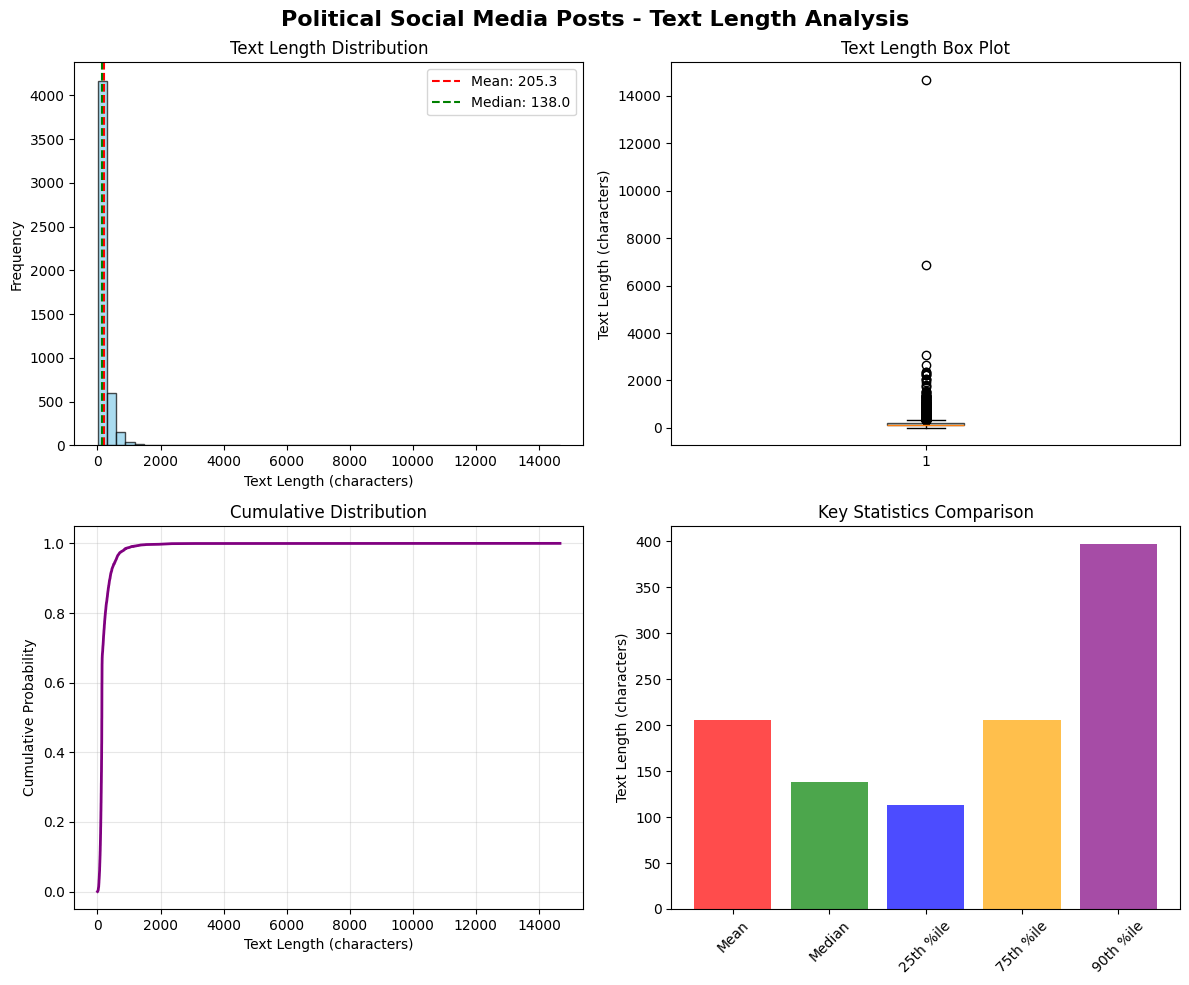

In [12]:
summary, df_w_lengths = analyze_text_length_simple(dfpsmfw, dataset_name="Political Social Media Posts")

# Tweet Topic Multi - Cardiffnlp

This set is from HuggingFace: https://huggingface.co/datasets/cardiffnlp/tweet_topic_multi

0: arts_&_culture	5: fashion_&_style	10: learning_&_educational	15: science_&_technology
1: business_&_entrepreneurs	6: film_tv_&_video	11: music	16: sports
2: celebrity_&_pop_culture	7: fitness_&_health	12: news_&_social_concern	17: travel_&_adventure
3: diaries_&_daily_life	8: food_&_dining	13: other_hobbies	18: youth_&_student_life
4: family	9: gaming	14: relationships

Politics can span a wide variety of topics, but definitely "news_&_social_concern"

```bash
@inproceedings{dimosthenis-etal-2022-twitter,
    title = "{T}witter {T}opic {C}lassification",
    author = "Antypas, Dimosthenis  and
    Ushio, Asahi  and
    Camacho-Collados, Jose  and
    Neves, Leonardo  and
    Silva, Vitor  and
    Barbieri, Francesco",
    booktitle = "Proceedings of the 29th International Conference on Computational Linguistics",
    month = oct,
    year = "2022",
    address = "Gyeongju, Republic of Korea",
    publisher = "International Committee on Computational Linguistics"
}
```

In [13]:
tweet_topic_multi_dataset = data_dir / 'tweet_topic_multi_og.parquet' # og for Original

# Saved
INITIAL_SAVE = False

if INITIAL_SAVE:
    dsttm = load_dataset("cardiffnlp/tweet_topic_multi")
    all_data = [dsttm['test_2019'].to_pandas(), dsttm['test_2021'].to_pandas(), dsttm['train_all'].to_pandas(), dsttm['validation_2020'].to_pandas(), dsttm['validation_2021'].to_pandas()]
    dfttm = pd.concat(all_data)
    dfttm.to_parquet(tweet_topic_multi_dataset)

dfttm = pd.read_parquet(tweet_topic_multi_dataset)
dfttm.head(5)

,text,date,label,label_name,id
0,Game day for {{USERNAME}} U18’s against {{USER...,2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[sports],1170606779568463874
1,⚽️ This afternoon we have our first League gam...,2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[sports],1170607436924952576
2,Might watch the {@Tennessee Titans@} game only...,2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[sports],1170666727845376000
3,. {@Asante Kotoko SC@} should have moved for t...,2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...","[fitness_&_health, news_&_social_concern, sports]",1170728379290673154
4,Massive WELL DONE to BSLFC Reserves today in t...,2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[sports],1170788768690970624


In [14]:
def analyze_text_length_multi_label(df, text_col='text', label_col='label_name'):
    """
    Analyze text length statistics for multi-label dataset.
    Each label becomes a separate entry for analysis.
    """
    print("=== MULTI-LABEL TEXT LENGTH ANALYSIS ===\n")
    
    # Expand rows so each label becomes a separate entry
    expanded_rows = []
    for idx, row in df.iterrows():
        text = row[text_col]
        text_length = len(text)
        labels = row[label_col] if isinstance(row[label_col], list) else [row[label_col]]
        
        # Handle different label formats - Error with Numpy
        if isinstance(labels, np.ndarray):
            labels = labels.tolist()
        elif isinstance(labels, str):
            labels = [labels]
        elif not isinstance(labels, list):
            labels = [labels]
        
        for label in labels:
            expanded_rows.append({
                'text': text,
                'text_length': text_length,
                'label': label
            })

    expanded_df = pd.DataFrame(expanded_rows)
    
    # Calculate statistics per label
    stats_summary = []
    labels = expanded_df['label'].tolist()
    labels_set = set()
    for labelz in labels:
        for lbl in labelz:
            labels_set.add(lbl)
    labels = list(labels_set)

    boxplotlist = []

    # for each label
    for label in sorted(labels):
        data_ex = expanded_df.copy()
        data_ex[label] = data_ex.apply(lambda x: label in x['label'], axis=1)
        label_data = data_ex[data_ex[label]] # expanded_df[label in expanded_df['label']] # ['text_length']
        label_data = label_data['text_length']
        boxplotlist.append(label_data.values)
        
        # Calculate statistics
        mean_len = label_data.mean()
        median_len = label_data.median()
        std_len = label_data.std()
        mode_result = stats.mode(label_data, keepdims=True)
        mode_len = mode_result.mode[0] if len(mode_result.mode) > 0 else np.nan
        
        # Percentiles
        p25 = label_data.quantile(0.25)
        p75 = label_data.quantile(0.75)
        p90 = label_data.quantile(0.90)
        p95 = label_data.quantile(0.95)
        
        stats_summary.append({
            'label': label,
            'count': len(label_data),
            'mean': mean_len,
            'median': median_len,
            'mode': mode_len,
            'std': std_len,
            'p25': p25,
            'p75': p75,
            'p90': p90,
            'p95': p95,
            'min': label_data.min(),
            'max': label_data.max()
        })
    
    stats_df = pd.DataFrame(stats_summary)
    
    # Display results
    print("Text Length Statistics by Label:")
    print("=" * 40)
    display_df = stats_df.round(2)
    print(display_df.to_string(index=False))
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Text Length Analysis by Label', fontsize=16, fontweight='bold')
    
    # 1. Box plot
    # label_lengths = [expanded_df[expanded_df['label'] == label]['text_length'].values 
    #     for label in sorted(labels)]
    axes[0, 0].boxplot(boxplotlist, labels=sorted(labels))
    axes[0, 0].set_title('Text Length Distribution by Label')
    axes[0, 0].set_ylabel('Text Length (characters)')
    axes[0, 0].tick_params(axis='x', rotation=90)
    
    # 2. Mean comparison bar chart
    axes[0, 1].bar(stats_df['label'], stats_df['mean'], color='skyblue', alpha=0.7)
    axes[0, 1].set_title('Average Text Length by Label')
    axes[0, 1].set_ylabel('Mean Text Length')
    axes[0, 1].tick_params(axis='x', rotation=90)
    
    # 3. Count of posts per label
    axes[1, 0].bar(stats_df['label'], stats_df['count'], color='lightcoral', alpha=0.7)
    axes[1, 0].set_title('Number of Posts by Label')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].tick_params(axis='x', rotation=90)
    
    # 4. Percentile comparison
    x_pos = np.arange(len(stats_df))
    width = 0.2
    axes[1, 1].bar(x_pos - width, stats_df['p25'], width, label='25th percentile', alpha=0.7)
    axes[1, 1].bar(x_pos, stats_df['median'], width, label='Median', alpha=0.7)
    axes[1, 1].bar(x_pos + width, stats_df['p75'], width, label='75th percentile', alpha=0.7)
    axes[1, 1].set_title('Percentile Comparison by Label')
    axes[1, 1].set_ylabel('Text Length')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(stats_df['label'], rotation=90)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return stats_df, expanded_df


=== MULTI-LABEL TEXT LENGTH ANALYSIS ===

Text Length Statistics by Label:
                   label  count   mean  median  mode   std    p25    p75   p90    p95  min  max
          arts_&_culture    403 175.47   176.0   102 66.87 114.00 231.50 263.8 277.00   50  347
business_&_entrepreneurs    436 194.31   201.0   217 65.25 141.00 252.00 275.0 284.00   56  353
 celebrity_&_pop_culture   1387 156.11   141.0    82 68.12  99.00 212.00 265.0 276.00   39  356
    diaries_&_daily_life   1194 178.83   178.5   192 67.80 121.00 237.00 272.0 280.00   38  338
                  family    326 177.69   183.0   216 66.14 118.25 227.75 269.0 279.00   45  307
         fashion_&_style    161 151.13   140.0   114 57.52 112.00 188.00 245.0 264.00   41  292
         film_tv_&_video   1468 161.32   151.0   151 67.22 105.00 216.00 265.0 276.00   44  352
        fitness_&_health    389 204.75   220.0   264 66.40 142.00 260.00 280.2 291.60   55  342
           food_&_dining    199 177.32   183.0   216 64.58 12

/tmp/ipykernel_1600/3890330512.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot(boxplotlist, labels=sorted(labels))


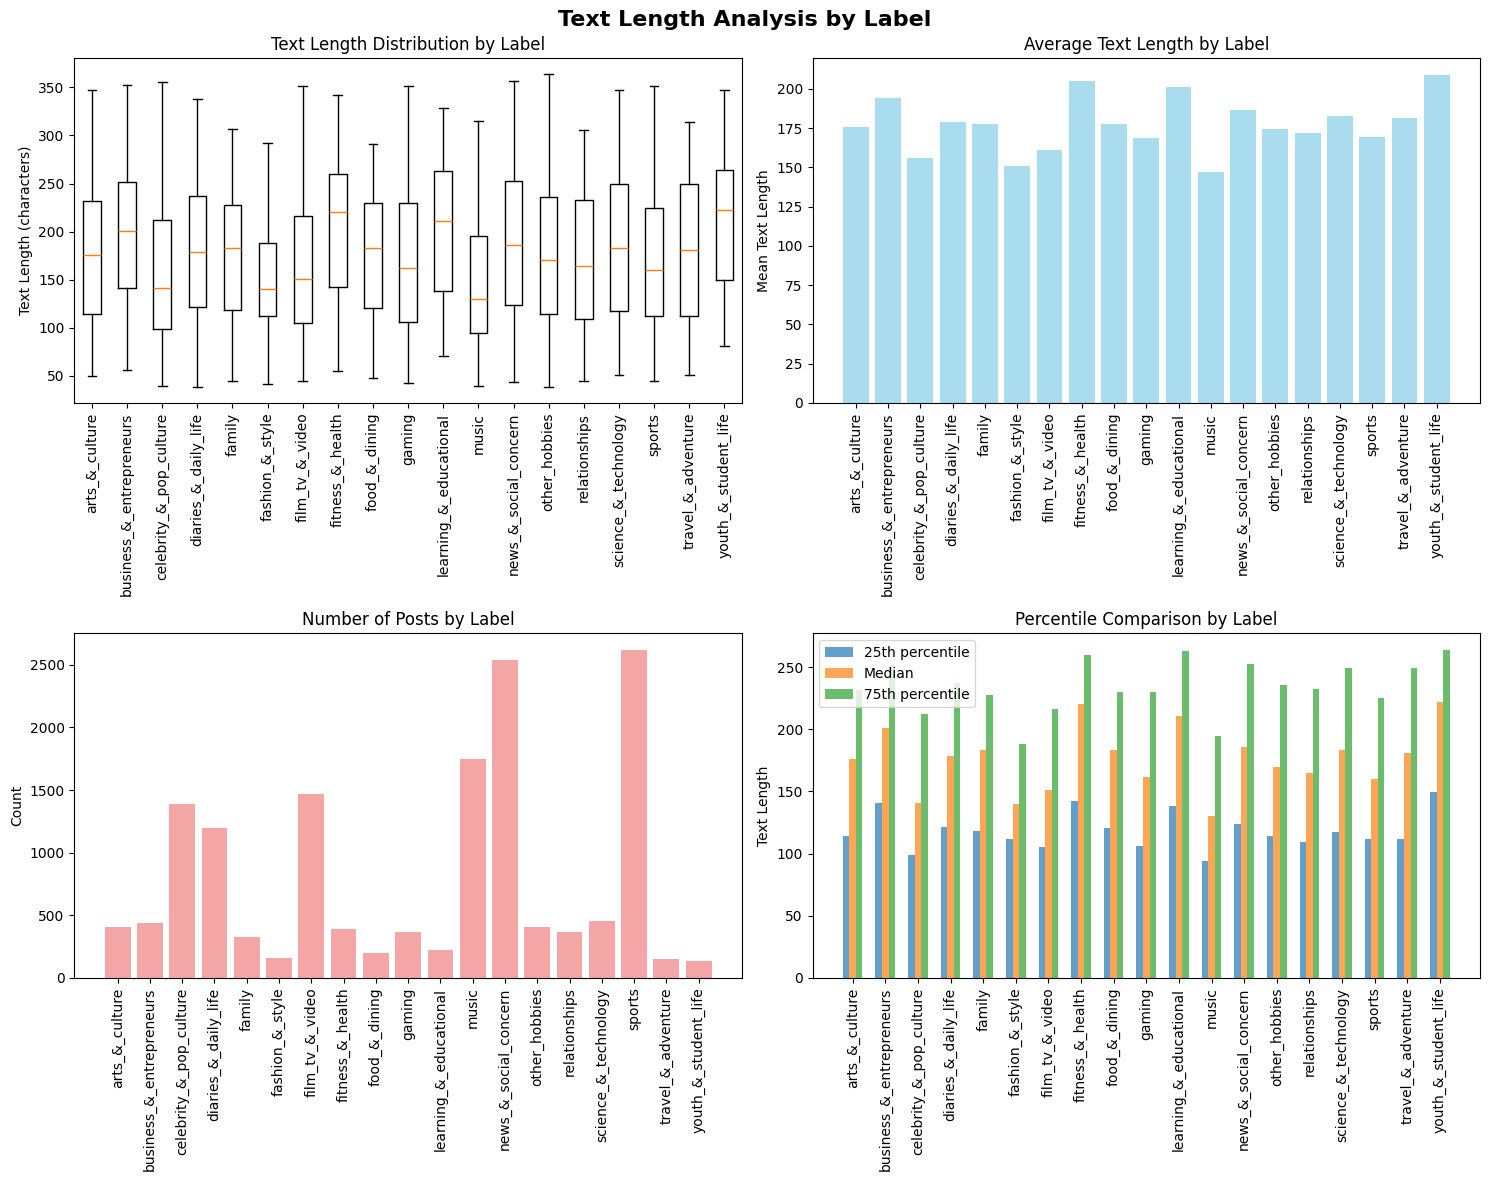

In [15]:
stats_df, expanded_df = analyze_text_length_multi_label(dfttm)

In [16]:
stats_df.head(20) #, expanded_df = analyze_text_length_multi_label(dfttm)

,label,count,mean,median,mode,std,p25,p75,p90,p95,min,max
0,arts_&_culture,403,175.473945,176.0,102,66.874102,114.00,231.50,263.8,277.00,50,347
1,business_&_entrepreneurs,436,194.314220,201.0,217,65.247116,141.00,252.00,275.0,284.00,56,353
2,celebrity_&_pop_culture,1387,156.107426,141.0,82,68.122328,99.00,212.00,265.0,276.00,39,356
3,diaries_&_daily_life,1194,178.829983,178.5,192,67.803353,121.00,237.00,272.0,280.00,38,338
4,family,326,177.690184,183.0,216,66.141799,118.25,227.75,269.0,279.00,45,307
5,fashion_&_style,161,151.130435,140.0,114,57.519359,112.00,188.00,245.0,264.00,41,292
6,film_tv_&_video,1468,161.318801,151.0,151,67.220049,105.00,216.00,265.0,276.00,44,352
7,fitness_&_health,389,204.748072,220.0,264,66.396212,142.00,260.00,280.2,291.60,55,342
8,food_&_dining,199,177.316583,183.0,216,64.583790,120.50,230.00,261.8,274.00,48,291
9,gaming,367,168.727520,162.0,81,69.064212,106.00,230.00,268.4,277.70,42,352


In [17]:
cnt = 0
for inx, row in expanded_df.iterrows():
    for lab in row['label']:
        # if "news" in lab or "business" in lab:
        if "news" in lab and len(lab) > 1:
            # print(json.dumps({
            #     'lab': lab,
            #     't': row['text']
            # }, indent=2))
            print(row['label'])
            cnt += 1
    if cnt > 10:
        break

['fitness_&_health' 'news_&_social_concern' 'sports']
['news_&_social_concern' 'sports']
['business_&_entrepreneurs' 'news_&_social_concern']
['news_&_social_concern']
['arts_&_culture' 'news_&_social_concern']
['news_&_social_concern']
['news_&_social_concern' 'science_&_technology']
['news_&_social_concern']
['news_&_social_concern' 'science_&_technology' 'youth_&_student_life']
['film_tv_&_video' 'news_&_social_concern' 'science_&_technology']
['learning_&_educational' 'music' 'news_&_social_concern'
 'science_&_technology']


# GLOBAL Political Tweets

https://www.kaggle.com/datasets/kaushiksuresh147/political-tweets

My focus is more on American politics, but looks like good and updated data (2022)

In [18]:
global_political_tweets_dataset = data_dir / 'global_political_tweets.parquet'
dfpt = pd.read_parquet(global_political_tweets_dataset)
dfpt.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,CPA Jim 2021,None,Grandparents enslaved by CCP since 1949 were b...,2011-03-17 10:17:36,711.0,146.0,1160.0,False,2021-07-30 23:57:05,US says seizes tanker used to evade North Kore...,"['politics', 'feedly']",Twitter Web App,False
1,Joint Minds,None,Joint Minds Podcast,2021-01-23 23:57:27,3.0,3.0,1.0,False,2021-07-30 23:53:21,Is America the greatest country? Part 1 drops ...,"['america', 'jointminds', 'politics', 'democra...",Twitter for iPhone,False
2,Sociafy,USA,Sociafy is an influencer-based content discove...,2011-09-30 05:59:06,36219.0,181.0,930.0,False,2021-07-30 23:53:03,O’Reilly predicts THIS is What DOOMS Biden’s r...,"['politics', 'videos']",Buffer,False
3,🟣 Discussions.app,United States,Home of Crypto Communities. $ATMOS \n\nhttps:/...,2017-02-09 23:15:24,2426.0,1104.0,8173.0,False,2021-07-30 23:51:00,Corruption in Politics\n#blog #politics \nhttp...,"['blog', 'politics']",TweetDeck,False
4,Ground News,"Kitchener, ON",The world's first news source comparison platf...,2018-02-08 22:00:16,13763.0,1224.0,2033.0,False,2021-07-30 23:50:53,@kylegriffin1 Are you getting all the info on ...,"['EvictionMoratorium', 'Congress', 'NancyPelos...",GroundNews,False


=== GLOBAL POLITICAL TWEETS TEXT LENGTH ANALYSIS ===

Text Length Statistics:
Dataset             : Global Political Tweets
Total Posts         : 238646
Mean                : 196.6
Median              : 190.0
Mode                : 217
Std Dev             : 69.44
25th Percentile     : 141.0
75th Percentile     : 261.0
90th Percentile     : 288.0
95th Percentile     : 302.0
Min                 : 15
Max                 : 1021


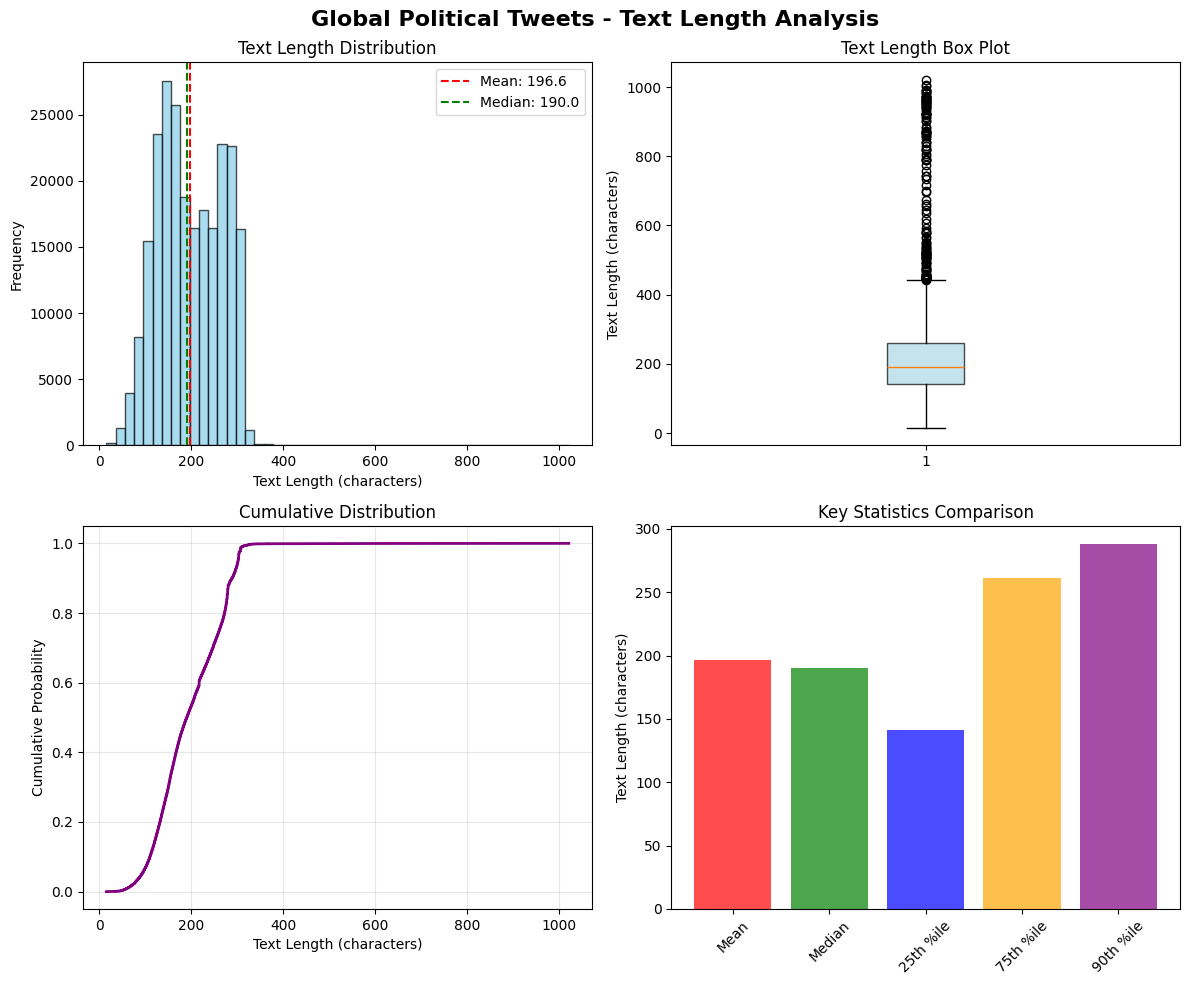

In [19]:
summary, df_w_lengths = analyze_text_length_simple(dfpt, dataset_name="Global Political Tweets")

In [20]:
def reverse_tweettopic_preprocessing(text):
    """
    Convert TweetTopic format back to regular @mentions
    """
    # Convert {@username@} back to @username
    text = re.sub(r'\{@([^@}]+)@\}', r'{{USERNAME}}', text)
    
    return text

# Example
tweettopic_text = "Thanks to {@herbiehancock@} and {{USERNAME}} for the music! {{URL}}"
restored_text = reverse_tweettopic_preprocessing(tweettopic_text)
print(restored_text)

Thanks to {{USERNAME}} and {{USERNAME}} for the music! {{URL}}


In [ ]:
def standardize_preprocessing(text):
    """
    Standard preprocessing for both TweetTopic and your political data
    """
    # First, reverse any existing TweetTopic formatting
    text = reverse_tweettopic_preprocessing(text)
    
    # Then apply consistent preprocessing
    # Replace URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '{{URL}}', text)
    
    # Replace all @mentions with {{USERNAME}}
    text = re.sub(r'@\w+', '{{USERNAME}}', text)
    
    return text

In [27]:
dfpsmfw['pre_text'] = dfpsmfw.apply(lambda x: standardize_preprocessing(x['text']), axis=1)
dfpsmfw['label'] = 'political'
print(dfpsmfw.columns)
dfpsmfw['pre_text'].head(10).to_list()
dfpsmfw.head(10)

Index(['id', 'bias', 'message', 'source', 'text', 'pre_text', 'label'], dtype='object')


,id,bias,message,source,text,pre_text,label
0,766192484,partisan,policy,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,RT {{USERNAME}}: Rep. Trey Radel (R- #FL) slam...,political
1,766192485,partisan,attack,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,VIDEO - #Obamacare: Full of Higher Costs and ...,political
2,766192486,neutral,support,twitter,Please join me today in remembering our fallen...,Please join me today in remembering our fallen...,political
3,766192487,neutral,policy,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,RT {{USERNAME}}: 1st step toward Senate debate...,political
4,766192488,partisan,policy,twitter,.@amazon delivery #drones show need to update ...,.{{USERNAME}} delivery #drones show need to up...,political
5,766192489,partisan,information,twitter,Called on the @USDOTFRA to release info about ...,Called on the {{USERNAME}} to release info abo...,political
6,766192490,neutral,mobilization,twitter,"@BBCWorld, help us keep the kidnapped Nigerian...","{{USERNAME}}, help us keep the kidnapped Niger...",political
7,766192491,neutral,mobilization,twitter,Show your Arizona pride-choose your favorite S...,Show your Arizona pride-choose your favorite S...,political
8,766192492,neutral,personal,twitter,What a wonderful night at State Senator Ken Ya...,What a wonderful night at State Senator Ken Ya...,political
9,766192493,partisan,support,twitter,Great op-ed by Pres. Clinton about signing #FM...,Great op-ed by Pres. Clinton about signing #FM...,political


In [40]:
dfpt['pre_text'] = dfpt.apply(lambda x: standardize_preprocessing(x['text']), axis=1)
dfpt['label'] = "political"
print(dfpt.columns)
dfpt['pre_text'].head(10).to_list()
dfpt.head(10)

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet', 'pre_text',
       'label'],
      dtype='object')


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,pre_text,label
0,CPA Jim 2021,None,Grandparents enslaved by CCP since 1949 were b...,2011-03-17 10:17:36,711.0,146.0,1160.0,False,2021-07-30 23:57:05,US says seizes tanker used to evade North Kore...,"['politics', 'feedly']",Twitter Web App,False,US says seizes tanker used to evade North Kore...,political
1,Joint Minds,None,Joint Minds Podcast,2021-01-23 23:57:27,3.0,3.0,1.0,False,2021-07-30 23:53:21,Is America the greatest country? Part 1 drops ...,"['america', 'jointminds', 'politics', 'democra...",Twitter for iPhone,False,Is America the greatest country? Part 1 drops ...,political
2,Sociafy,USA,Sociafy is an influencer-based content discove...,2011-09-30 05:59:06,36219.0,181.0,930.0,False,2021-07-30 23:53:03,O’Reilly predicts THIS is What DOOMS Biden’s r...,"['politics', 'videos']",Buffer,False,O’Reilly predicts THIS is What DOOMS Biden’s r...,political
3,🟣 Discussions.app,United States,Home of Crypto Communities. $ATMOS \n\nhttps:/...,2017-02-09 23:15:24,2426.0,1104.0,8173.0,False,2021-07-30 23:51:00,Corruption in Politics\n#blog #politics \nhttp...,"['blog', 'politics']",TweetDeck,False,Corruption in Politics\n#blog #politics \n{{URL}},political
4,Ground News,"Kitchener, ON",The world's first news source comparison platf...,2018-02-08 22:00:16,13763.0,1224.0,2033.0,False,2021-07-30 23:50:53,@kylegriffin1 Are you getting all the info on ...,"['EvictionMoratorium', 'Congress', 'NancyPelos...",GroundNews,False,{{USERNAME}} Are you getting all the info on #...,political
5,Mike Staub,"San Francisco, CA","Developer, Artist, Investor, Entrepreneur, Eff...",2009-07-09 04:07:49,495.0,2681.0,6930.0,False,2021-07-30 23:50:15,90% of US drone strikes kill civilians. An ope...,"['politics', 'justice', 'war']",Twitter Web App,False,90% of US drone strikes kill civilians. An ope...,political
6,Bingxo News,United States,"Comprehensive, up-to-date news coverage, aggre...",2017-07-24 07:39:02,340.0,114.0,1.0,False,2021-07-30 23:49:09,"100,000-Year-Old Fossil of Largest-Ever Vampir...","['news', 'covid', 'usa', 'canada', 'uk', 'inst...",IFTTT,False,"100,000-Year-Old Fossil of Largest-Ever Vampir...",political
7,joshua epstein🏳️‍🌈🖖🏼🗽👨🏼‍💻🇺🇸,new york city,Gay Progressive Patriot. #NYC's the greatest c...,2008-06-20 18:32:27,6451.0,2806.0,4257.0,False,2021-07-30 23:49:03,Via @RawStory: 'People will die': Congress bla...,"['politics', 'trump', 'corruption']",dlvr.it,False,Via {{USERNAME}}: 'People will die': Congress ...,political
8,tweetbud,GOD BLESS AMERICA,sick of politicians games,2010-04-27 03:07:03,368.0,378.0,28408.0,False,2021-07-30 23:47:23,😮👇 gave me a lesson on the percentage of #vote...,"['voters', 'Texas', 'Politics']",Twitter for Android,False,😮👇 gave me a lesson on the percentage of #vote...,political
9,Chris Eastaughffe (AZ Vac done),"Queensland, Australia.","Company Director, Investigator, Author. Exper...",2013-05-08 02:16:00,275.0,70.0,8411.0,False,2021-07-30 23:46:56,Please watch... the #US and #UK actually ran t...,"['US', 'UK', 'Chinese', 'CCP', 'debt', 'politi...",Twitter Web App,False,Please watch... the #US and #UK actually ran t...,political


In [39]:
dfttm['pre_text'] = dfttm.apply(lambda x: reverse_tweettopic_preprocessing(x['text']), axis=1)
dfttm['label'] = dfttm.apply(lambda x: "political" if any([True if "news" in x else False for x in x['label_name']])  else "other", axis=1)
print(dfttm.columns)
dfttm['pre_text'].head(10).to_list()
dfttm.head(10)

Index(['text', 'date', 'label', 'label_name', 'id', 'pre_text', 'old_label'], dtype='object')


,text,date,label,label_name,id,pre_text,old_label
0,Game day for {{USERNAME}} U18’s against {{USER...,2019-09-08,other,[sports],1170606779568463874,Game day for {{USERNAME}} U18’s against {{USER...,other
1,⚽️ This afternoon we have our first League gam...,2019-09-08,other,[sports],1170607436924952576,⚽️ This afternoon we have our first League gam...,other
2,Might watch the {@Tennessee Titans@} game only...,2019-09-08,other,[sports],1170666727845376000,Might watch the {{USERNAME}} game only to see ...,other
3,. {@Asante Kotoko SC@} should have moved for t...,2019-09-08,political,"[fitness_&_health, news_&_social_concern, sports]",1170728379290673154,. {{USERNAME}} should have moved for this Pres...,other
4,Massive WELL DONE to BSLFC Reserves today in t...,2019-09-08,other,[sports],1170788768690970624,Massive WELL DONE to BSLFC Reserves today in t...,other
5,SOCCER CHANGES TODAY vs {{USERNAME}} JV moved ...,2019-09-12,other,"[gaming, sports]",1172207842163679234,SOCCER CHANGES TODAY vs {{USERNAME}} JV moved ...,other
6,WATCH {{USERNAME}} vs {@St Kilda FCW@} on the ...,2019-09-15,other,[sports],1173052768442994690,WATCH {{USERNAME}} vs {{USERNAME}} on the #VFL...,other
7,Keep going armylegend #PCAs #BoyWithLuv #TheM...,2019-09-15,other,"[celebrity_&_pop_culture, film_tv_&_video, music]",1173112190527627265,Keep going armylegend #PCAs #BoyWithLuv #TheM...,other
8,#INDvSA | Coach Ravi Shastri and Shikhar Dhawa...,2019-09-15,political,"[news_&_social_concern, sports]",1173114193333014529,#INDvSA | Coach Ravi Shastri and Shikhar Dhawa...,other
9,Rohit As An Opener * IN ODI - Played 1st Matc...,2019-09-15,other,[sports],1173173657440403456,Rohit As An Opener * IN ODI - Played 1st Matc...,other


In [42]:
df_list = [dfpsmfw[['pre_text', 'label']], dfpt[['pre_text', 'label']], dfttm[['pre_text', 'label']]]
dfcombo = pd.concat(df_list)
dfcombo = dfcombo.sample(frac=1, replace=False, ignore_index=True)
dfcombo.head(15)

,pre_text,label
0,#BTC #ETH #economy #politics #Metaverse #shiba...,political
1,A government task force has been set up to con...,political
2,Alleged Genovese family mobster accused of “bu...,political
3,It's not only about #US #strategy #power but i...,political
4,I hope that we have a kinder #Politics and #Th...,political
5,He urges people to create a mass upsurge to de...,political
6,Anti-abortionists \nAssemble \nOn the wrong si...,political
7,Extreme Heat Could Also Mean Power and Water S...,political
8,"Follow us {{USERNAME}} for more politics, crit...",political
9,There are THREE branches of the government. Ca...,political


In [ ]:
dfcombo['label'].value_counts()

label
political    246186
other          6563
Name: count, dtype: int64

In [60]:
if True:
    dfcombo.to_parquet(data_dir / 'partial_full20250819.parquet')

In [56]:
# bring in Sentiment140
# seniment140_data = data_dir / 'sentiment140.csv'
seniment140_data = data_dir / 'sentiment140.parquet'
if False:
    with open(seniment140_data, 'rb') as file:
        print(chardet.detect(file.read(10000000))) # 10MB
        # {'encoding': 'utf-8', 'confidence': 0.9, 'language': ''}
# dfset = pd.read_csv(data_dir / 'sentiment140.csv', encoding='utf-8', encoding_errors='ignore', sep=',', header=None, 
#     names=[
#         "polarity",
#         "ids",
#         "date",
#         "query",
#         "user",
#         "text"
#     ])
# dfset.to_parquet(data_dir / 'sentiment140.parquet')
dfset = pd.read_parquet(seniment140_data)

In [57]:
print(dfset.columns)
dfset.head()

Index(['polarity', 'ids', 'date', 'query', 'user', 'text'], dtype='object')


,polarity,ids,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [58]:
dfset.describe()

,polarity,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [59]:
dfset['pre_text'] = dfset.apply(lambda x: standardize_preprocessing(x['text']), axis=1)

Maybe a solution exists?

- "m-newhauser/distilbert-political-tweets"  # Already trained for political classification
- "cardiffnlp/twitter-roberta-base-sentiment"  # Not DistilBERT but good for social media

Neither is what I am looking for

In [ ]:
# Load the pre-trained political tweets model
model_name = "m-newhauser/distilbert-political-tweets"
# model_name = "cardiffnlp/twitter-roberta-base-sentiment"
print(f"Loading model: {model_name}")

try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    print("✅ Model loaded successfully!")
    
    # Check model configuration
    print(f"\nModel info:")
    print(f"- Number of labels: {model.config.num_labels}")
    print(f"- Label mapping: {model.config.id2label}")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Falling back to base DistilBERT...")
    
    # Fallback to base model if the political one doesn't work
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", 
        num_labels=2
    )

def predict_political_sentiment(text, return_probabilities=False):
    """
    Predict if text has Democratic or Republican sentiment
    
    Args:
        text (str): Input text to classify
        return_probabilities (bool): If True, return probabilities for both classes
    
    Returns:
        dict: Prediction results
    """
    # Tokenize the input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Get model predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()
        
        # Get label names if available
        if hasattr(model.config, 'id2label'):
            predicted_label = model.config.id2label[predicted_class]
            labels = [model.config.id2label[i] for i in range(model.config.num_labels)]
        else:
            predicted_label = f"Class {predicted_class}"
            labels = [f"Class {i}" for i in range(model.config.num_labels)]
        
        result = {
            'predicted_class': predicted_class,
            'predicted_label': predicted_label,
            'confidence': probabilities[0][predicted_class].item()
        }
        
        if return_probabilities:
            result['all_probabilities'] = {
                labels[i]: probabilities[0][i].item() 
                for i in range(len(labels))
            }
        
        return result

# Test with sample political tweets
test_tweets = [
    "We need to invest more in clean energy and fight climate change for our children's future.",
    "Lower taxes and less government regulation will help our economy grow stronger.",
    "Healthcare is a human right and should be accessible to all Americans.",
    "We must secure our borders and enforce immigration laws to protect American workers.",
    "Education funding should be increased to give every child a chance at success.",
    "The Second Amendment protects our fundamental right to bear arms.",
    "Social Security and Medicare must be protected for our seniors.",
    "Free market capitalism is the best system for creating prosperity and opportunity."
]

print("\n" + "="*80)
print("TESTING POLITICAL SENTIMENT CLASSIFICATION")
print("="*80)

for i, tweet in enumerate(test_tweets, 1):
    print(f"\n{i}. Tweet: \"{tweet}\"")
    
    try:
        # Get prediction
        result = predict_political_sentiment(tweet, return_probabilities=True)
        
        print(f"   Prediction: {result['predicted_label']}")
        print(f"   Confidence: {result['confidence']:.3f}")
        
        if 'all_probabilities' in result:
            print("   All probabilities:")
            for label, prob in result['all_probabilities'].items():
                print(f"     {label}: {prob:.3f}")
                
    except Exception as e:
        print(f"   ❌ Error predicting: {e}")

# Function to test your own tweets
def test_your_tweets():
    """
    Interactive function to test your own tweets
    """
    print("\n" + "="*50)
    print("TEST YOUR OWN TWEETS")
    print("="*50)
    print("Enter tweets to classify (press Enter with empty text to stop):")
    
    while True:
        user_tweet = input("\nEnter tweet: ").strip()
        if not user_tweet:
            print("Testing complete!")
            break
            
        try:
            result = predict_political_sentiment(user_tweet, return_probabilities=True)
            print(f"Prediction: {result['predicted_label']} (confidence: {result['confidence']:.3f})")
            
            if 'all_probabilities' in result:
                for label, prob in result['all_probabilities'].items():
                    print(f"  {label}: {prob:.3f}")
                    
        except Exception as e:
            print(f"Error: {e}")

# Function to test on your dataframe
def test_on_dataframe(df, text_column='text', sample_size=10):
    """
    Test the model on a sample of your dataframe
    
    Args:
        df: pandas DataFrame with tweets
        text_column: name of column containing text
        sample_size: number of samples to test
    """
    print(f"\n" + "="*50)
    print(f"TESTING ON DATAFRAME SAMPLE ({sample_size} tweets)")
    print("="*50)
    
    sample_df = df.sample(n=min(sample_size, len(df)))
    
    predictions = []
    for idx, row in sample_df.iterrows():
        text = row[text_column]
        try:
            result = predict_political_sentiment(text)
            predictions.append({
                'original_index': idx,
                'text': text[:100] + "..." if len(text) > 100 else text,
                'prediction': result['predicted_label'],
                'confidence': result['confidence']
            })
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
    
    # Display results
    for i, pred in enumerate(predictions, 1):
        print(f"\n{i}. \"{pred['text']}\"")
        print(f"   → {pred['prediction']} (confidence: {pred['confidence']:.3f})")
    
    return predictions

print(f"\n" + "="*80)
print("USAGE EXAMPLES:")
print("="*80)
print("1. Test your own tweets:")
print("   test_your_tweets()")
print("\n2. Test on your dataframe:")
print("   predictions = test_on_dataframe(your_df, text_column='text', sample_size=5)")
print("\n3. Single prediction:")
print("   result = predict_political_sentiment('Your tweet here')")
print("="*80)

Loading model: cardiffnlp/twitter-roberta-base-sentiment
✅ Model loaded successfully!

Model info:
- Number of labels: 3
- Label mapping: {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}

TESTING POLITICAL SENTIMENT CLASSIFICATION

1. Tweet: "We need to invest more in clean energy and fight climate change for our children's future."


/home/ksull18/code/iu-autonomous-fact-checker/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


   Prediction: LABEL_2
   Confidence: 0.508
   All probabilities:
     LABEL_0: 0.045
     LABEL_1: 0.447
     LABEL_2: 0.508

2. Tweet: "Lower taxes and less government regulation will help our economy grow stronger."
   Prediction: LABEL_2
   Confidence: 0.923
   All probabilities:
     LABEL_0: 0.004
     LABEL_1: 0.073
     LABEL_2: 0.923

3. Tweet: "Healthcare is a human right and should be accessible to all Americans."
   Prediction: LABEL_2
   Confidence: 0.775
   All probabilities:
     LABEL_0: 0.014
     LABEL_1: 0.212
     LABEL_2: 0.775

4. Tweet: "We must secure our borders and enforce immigration laws to protect American workers."
   Prediction: LABEL_1
   Confidence: 0.717
   All probabilities:
     LABEL_0: 0.142
     LABEL_1: 0.717
     LABEL_2: 0.141

5. Tweet: "Education funding should be increased to give every child a chance at success."
   Prediction: LABEL_2
   Confidence: 0.754
   All probabilities:
     LABEL_0: 0.014
     LABEL_1: 0.233
     LABEL_2: 0.754

6.

In [62]:
test_on_dataframe(dfset, text_column='text', sample_size=25)


TESTING ON DATAFRAME SAMPLE (25 tweets)

1. "@thisisryanross i like the rain "
   → Democrat (confidence: 1.000)

2. "@justinkendall I've been delaying work, as well...playing is def mindless &amp; is a good distractio..."
   → Democrat (confidence: 0.999)

3. "is knackered! Gonna go for Banksy Exhibithion in a bit. Joel and JJ is coming to get me. Please don'..."
   → Democrat (confidence: 0.847)

4. "like usual i can't sleep "
   → Republican (confidence: 0.755)

5. "@WMSPhotography you just hurt my feelings "
   → Republican (confidence: 1.000)

6. "What else to do on a rainy day beside staying home? I can't go on a bike ride with my cousins "
   → Democrat (confidence: 0.934)

7. "There's zero chance of me being hit on here. "
   → Democrat (confidence: 0.943)

8. "@ashleycauthen  Invite my to your party "
   → Republican (confidence: 1.000)

9. "Wondering what all the twitter is about! "
   → Democrat (confidence: 0.752)

10. "I have now welcomed Martha into Bridgwater, things ar

[{'original_index': 1062987,
  'text': '@thisisryanross i like the rain ',
  'prediction': 'Democrat',
  'confidence': 0.9999765157699585},
 {'original_index': 1235170,
  'text': "@justinkendall I've been delaying work, as well...playing is def mindless &amp; is a good distractio...",
  'prediction': 'Democrat',
  'confidence': 0.9989328980445862},
 {'original_index': 601000,
  'text': "is knackered! Gonna go for Banksy Exhibithion in a bit. Joel and JJ is coming to get me. Please don'...",
  'prediction': 'Democrat',
  'confidence': 0.8465920686721802},
 {'original_index': 71839,
  'text': "like usual i can't sleep ",
  'prediction': 'Republican',
  'confidence': 0.7545745372772217},
 {'original_index': 584701,
  'text': '@WMSPhotography you just hurt my feelings ',
  'prediction': 'Republican',
  'confidence': 0.9999771118164062},
 {'original_index': 94634,
  'text': "What else to do on a rainy day beside staying home? I can't go on a bike ride with my cousins ",
  'prediction': 'Dem